Initially a series of data structures, files and functions that have to be utilized throughout the analysis have to be stored in the current directory space.  
The code below is responsible for downloading the aforementioned data from the storage space.

The cfg.py file is used for updating and importing all useful libraries to be used throughout the analysis.
Moreover, all functions/classes inside cfg.py (find_notebook, NotebookLoader, NotebookFinder) were taken from a tutorial on how to import external jupyter notebooks as modules.  
Documentations about the aforementioned functions and classes can be found in this link:  
https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Importing%20Notebooks.html  
The code below is responsible for downloading the aforementioned data from the storage space.  

In this step a series of libraries whose classes and functions have to be utilized throughout the analysis,  
are being downloaded from the storage space and imported as modules.

In [1]:
import os
from subprocess import call
import pickle as pk
from IPython.display import clear_output
current_dir = os.listdir('./')
for path in os.listdir('../25 3 2019/'):
    if os.path.islink(path) is not True and path not in current_dir:
        call(['ln','-s','../25 3 2019/'+ path, path])        
from cfg import *
os.chdir('../CCP_Collab_Backup_2/')
import PrimaryLibrary as PL
imp.reload(PL)
import MorphologyLibrary as MLab
imp.reload(MLab)
import Allen_API_Library as API
imp.reload(API)
MesoPred = PL.MesoconnectomePredictor()

importing Jupyter notebook from Allen_API_Library.ipynb
importing Jupyter notebook from Allen_API_Library.ipynb


In this cell, an initialization of an sbaInterface_class instance is being made.
The sbaInterface_class serves as an API for calling the Scalable Brain Composer (SBA)  brain visualization tool. As shown by the steps below, we will use the SBA for a series of visualizations.  
As soon as the initialization is being made, a window will pop-up. On later steps, values will be passed to SBA which will lead to visualizations displayed in the aforementioned window.

In [2]:
# SBA Composer page to load: here it is the -dev version and atlas ABA_v3
sbaHost = 'https://sba-dev.incf.org/composer'
sbaUrl  = sbaHost + '/index.php?template=ABA_v3&scene={"background":"FFFFFF"}' 
sbaInterface = PL.sbaInterface_class(sbaHost,sbaUrl)  

## Parameter Initialization

Initializing the parameters of the supervised learning models to be used.  
The models applied in this analysis are: 
*  regression     = Random Forest regressor,  Ridge regressor

In [3]:
GeneExp        = h5py.File('G_Exp.hdf5', 'r')['dataset1']
ConDict        = pk.load(open('CreLineDict.pkl','rb'))

Before the analysis initiation, an instance of class MesoconnectomePredictor is being created (MesoPred) in order to load and manipulate the connectivity pattern data.

In [4]:
MesoPred = PL.MesoconnectomePredictor()

The leaf_keys contain information about target areas that are present on the finest possible level of description.
For instance areas called VISp (primary visual area) and VISp l1 (primary visual area, layer 1) could both be found 
in the dataset, and therefore the leaf_keys are being used to filter out VISp as a non-leaf key in the structure hierarchy
since a finer description is present (VISp l1). Hence, the targetprofiles dictionary of the MesoPred instance that contains information about the acronyms of all target brain areas shall be reduced to the leaf level.

In [5]:
for key in MesoPred.targetprofiles.keys():
    MesoPred.targetprofiles[key] = [val for idx,val in enumerate(MesoPred.targetprofiles[key]) if idx in MesoPred.params['leaf_keys']]

## Predictive Pipeline  
### Author: Nestor Timonidis
In our examples I utilize the unionized anatomical tract tracing data taken from the Allen Institute for Brain Science, as shown in the Allen_API_Library notebook. The data come in the form of a dictionary with nested matrices, where each dictionary corresponds to a tracer category like wild type or Syt6-Cre_KI148 cre-line experiments for instance.   
In order to demonstrate the MesoPred tool, a number of categories are selected as shown below. This analysis can take a while if run for all possible tracer categories. Therefore, for reasons of time efficiency one could skip this cell and move to the next one where the results can be loaded by stored pickle files.

In this pipeline a number of steps is being followed:  
0.  Conversion of the gene expression data to numpy array format for computational simplicity, initialization of various dictionaries to store analysis related data and results per tracer category (key). Selection of the tracer category (driver) of interest, reduction of tracing data and gene expression data to the leaf-level structures and storage of a number of parameters to be used in the analysis, such as the layer profiles and acronyms of the target areas of the dataset.    
1.  Preprocessing of the gene expression and tract tracing data. The function called in that step is PreProcessing
2.  Prediction with a logistic or linear ridge regression model using the cross-validation method for performance evaluation. The function called in that step is CustomCrossval.
3.  Prediction with a random forest classifier or regressor model using the cross-validation method for performance evaluation. The function called in that step is CustomCrossval.
4.  Prediction with a control (baseline) model using the cross-validation method for performance evaluation. The function called in that step is CustomCrossval.
5.  Storage of the predicted connectivity patterns, probability scores and gene importance (coefficient) scores per tracer in dictionaries stratified by the tested driver categories. The function called in that step is UnravelResults.
6.  Based on the stored connectivity patterns and the actual (ground truth) ones, evaluation of the predictive process with series of statistical measures. Examples include r squared and root mean squared error for regression, and f1-score and area under the roc curve for classification. The function called in that step is Evaluation.
8. Estimate the stability of the fittest model based on the optimal hyperparameters selected for each fold of the CustomCrossval function (step 3). In case that the model is considered as stable, then the model fits the whole data with the optimal hyperparameters.     

### Input:
    *   ConDict = dictionary with connectivity strength patterns per structural brain area used throughout the pipeline.
    *   GeneExp = 2D array with gene expression values per structural brain area used throughout the pipeline.
    *   params  = additional parameters specifying analysis details throughout the pipeline.  
    
### Output:
    *   ClfResults_ridge = dictionary with predictive results of the main model (ridge in that instance).

In [6]:
ClfResults_ridge = MesoPred.PredictivePipeline(ConDict, GeneExp)
clear_output()

In case that a set of results from a number of tracer categories have been stored,  
they can be loaded as shown below in order to save time.   
The data from the ridge regression model are being used   
due to the model's superior performance over the rest of  
the models as shown by the cross-validation evaluation method.

In [14]:
ClfResults_ridge = {} 
MesoPred.params           = pk.load(open('updated_params.pkl','rb'))
for key in ConDict.keys():
    if os.path.isfile(MesoPred.params['prefix'] + key + '_all_results' + '_total.pkl') == True:
        infile = MesoPred.params['prefix'] + key + '_all_results' + '_total.pkl'
        print infile
        tmp = pk.load(open(infile,'rb'))
        ClfResults_ridge[key] = {key:val for key,val in tmp['ridge'].items()}
        
clear_output()      

One of the last demonstrations regarding the predictive pipeline is about binarized connectivity patterns. This could be useful in the case that a particular researcher is not interested in the connectivity strength between two brain areas but in the presence of connections between areas, whose strength exceeds a certain threshold. For that reason, the Convert2ROC function is being called for all predicted connectivity patterns.     
The idea is the utilize the Area under the ROC curve (AURoc) as an evaluation measure in order to estimate the most optimal binarizing threshold. The threshold for which the AURoc is being maximized is selected as the most optimal. 
The steps that describe this procedure are being explained in the Convert2ROC function.   
More information about the AURoc measure can be found at:   
https://en.wikipedia.org/wiki/Receiver_operating_characteristic

In [17]:
cutoff_col = {}
for driver_line in ClfResults_ridge.keys():
    ClfResults_ridge[driver_line]['cutoff'] = MesoPred.Convert2ROC(ClfResults_ridge[driver_line]['y_actual'],
                                                                   ClfResults_ridge[driver_line]['y_preds'])
    print 'driver line: {} - cutoff example: {}'.format(driver_line, ClfResults_ridge[driver_line]['cutoff'][0][0]*0.01)

clear_output()
    

Lets take the case where we want to binarize the connectivity patterns in experiments belonging to the cre-line tracers tested in our analysis such as Cre_GN220. We utilize the our results from the previous function as shown below .

In [18]:
for driver_line in ClfResults_ridge.keys():
    outfile = MesoPred.params['prefix'] + driver_line + '_all_results'
    print driver_line
    experiments_len = np.shape(ClfResults_ridge[driver_line]['y_actual'])[1]
    ClfResults_ridge[driver_line]['binary_patterns'] = np.zeros(np.shape(ClfResults_ridge[driver_line]['y_actual']))
    for tracer_num in range(experiments_len):  
        ClfResults_ridge[driver_line]['binary_patterns'][:,tracer_num] = PL.BinarizeTheVector\
                                                         (ClfResults_ridge[driver_line]['y_actual'][:,tracer_num],\
                                                            ClfResults_ridge[driver_line]['cutoff'][tracer_num][0])
    pk.dump(ClfResults_ridge[driver_line], open(outfile + '_ridge.pkl','wb'))        

clear_output()    

## VISUALIZATION SECTION  
### Authors: Nestor Timonidis, Paul Tiesinga, Rembrandt Bakker
In this section, a number of steps are being followed   
for visualizing brain slices containing gene expression   
or connectivity information


Utilization of the MouseConnectivityCache (mcc) tool, provided by the Allen Institute for Brain Science Software Development Toolkit (SDK) at:  
https://alleninstitute.github.io/AllenSDK/_modules/allensdk/core/mouse_connectivity_cache.html    
The cortical flatmap templates used in this analysis, were downloaded from the informatics-archive of the Allen Institute for Brain Science:   
http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/cortical_coordinates/ccf_2016/  
The cortical_map_10.py script is a slightly modified version of the cortical_map.py script that was provided by the Allen Institute's github as part of the mouse_connectivity_models tool:   
https://github.com/AllenInstitute/mouse_connectivity_models  
The difference with the original script is that cortical_map_10 is modified to incorprorate cortical flatmap templates of 10 micrometer resolution.  
With the mcc tool, the annotation volume of the mouse brain is being downloaded in both 25 and 10 micrometer resolution for visualization purposes.

### Application of a set of experiment ids in the brain visualization tools (Brain Plotter)  

Selection of the 11th experiment of the Ntsr1-Cre-line for demonstration of the BrainPlotter tool.   
Data structures for storing the mapping of unionized projections to volumetric scale,  
for the actual and predicted patterns, are being initialized.  
Moreover, the dictionary that maps the identities of structures to their positions  
in the original raw unionized dataset is being updated to include only the   
structures that were used in the predictive pipeline.  

In [19]:
experiment_to_vis = [10]
tracer_for_selection = 'Ntsr1-Cre_GN220'
with open('structures.csv','rb') as fp:
    structure = PL.readtable(fp)  
    struct_idx_dict = {val:idx for idx,val in enumerate(structure['id'])}

For each one of the selected experiments:  
0.   Initializing the data for usage during the visualization process.
1.   Initialization of the BrainPlotter class instances.
2.   Call of the fit function that maps unionized projections to volumetric space for the selected projection patterns, using the FromUnion2Voxel function. Fit is being called for both 10 and 25 micrometers, since the cortical flatmap visualization requires 10 micrometer resolution, while the brain slice visualization requires 25 micrometers.
3.   Call of the plot_slice function to visualizing projections of the currently selected experiment in the superior-inferior and left-right coordinates using a brain slice.
4.   Call of the plot_flatmap function to visualizing projections of the currently selected experiment on the mouse cortex, using a cortical flatmap.

/home/ntimonidis/Brain-Connectivity Project/CCP_Collab_Backup_2
/home/ntimonidis/Brain-Connectivity Project/CCP_Collab_Backup_2
/home/ntimonidis/Brain-Connectivity Project/CCP_Collab_Backup_2
/home/ntimonidis/Brain-Connectivity Project/CCP_Collab_Backup_2


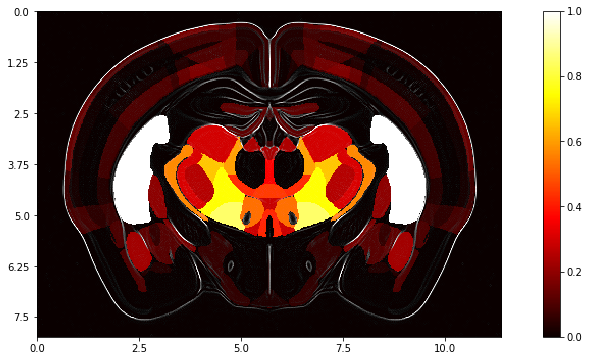

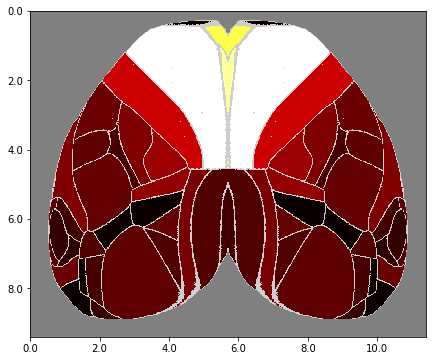

Elapsed time: 11.4069135666


In [20]:
for j,experiment in enumerate(experiment_to_vis):
    
    # Step 1
    key_to_save = tracer_for_selection + '_' + str(j)
    exp_id = ConDict[tracer_for_selection]['id'][j]
    Actual_ConStr = ClfResults_ridge[tracer_for_selection]['y_actual']
    start = time.time()
    
    # Step 2
    BP_10 = PL.BrainPlotter(exp_id = exp_id, resolution = 10) 
                         
    BP_25 = PL.BrainPlotter(exp_id = exp_id, resolution = 25)
    
    # Step 3
    BP_10.fit(projection = Actual_ConStr[:,experiment], chosen_indices = MesoPred.params['remaining_indices'])
    BP_25.fit(projection = Actual_ConStr[:,experiment], chosen_indices = MesoPred.params['remaining_indices'])
    
    # Step 4
    BP_25.plot_slice()
        
    # Step 5    
    BP_10.plot_flatmap()
    end = time.time() 
    print  'Elapsed time: ' + str((end - start)/60)
    

We are also interested in producing the aforementioned figures with the actual raw volumetric data. Therefore, steps 3-5 are repeated without giving any volumetric matrix as input to the plot_slice and plot_flatmap functions. In that case, the identities of the original experiments are used to download and visualize the actual raw data.

/home/ntimonidis/Brain-Connectivity Project/CCP_Collab_Backup_2


2020-04-01 13:23:21,549 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/159552290?image=projection_density&resolution=10
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/grid_data/download_file/159552290?image=projection_density&resolution=10


/home/ntimonidis/Brain-Connectivity Project/CCP_Collab_Backup_2


2020-04-01 13:25:29,036 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/159552290?image=projection_density&resolution=25
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/grid_data/download_file/159552290?image=projection_density&resolution=25


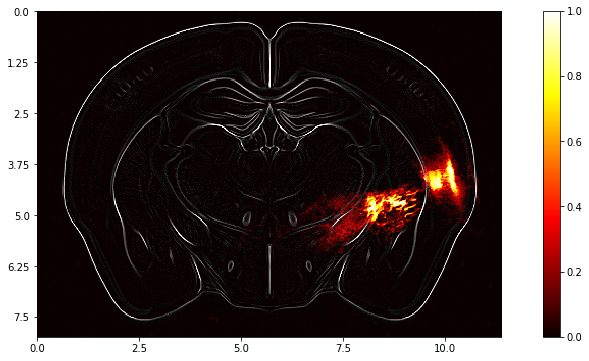

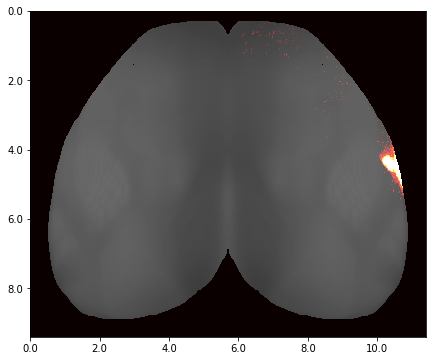

Elapsed time: 3.45175815026


In [21]:
for j,experiment in enumerate(experiment_to_vis):
    
    # Step 0
    exp_id = ConDict[tracer_for_selection]['id'][j]
    start = time.time()
    
    # Step 1
    #driver = tracer_for_selection + str(exp_id))
    BP_10 = PL.BrainPlotter(exp_id = exp_id, resolution = 10) 
                         
    BP_25 = PL.BrainPlotter(exp_id = exp_id, resolution = 25)
    
    # Step 2
    BP_10.fit()
    BP_25.fit()
    
    # Step 4
    BP_25.plot_slice()
        
    # Step 5    
    BP_10.plot_flatmap()
    end = time.time() 
    print  'Elapsed time: ' + str((end - start)/60)
    

## Link to Scalable Brain Atlas Composer Section
### Authors: Rembrandt Bakker, Nestor Timonidis

In this part, the Scalable Brain Atlas (SBA) Composer visualization tool is being used to visualize actual and predicted data that have been used and processed throughout the analysis.      
The website of the SBA Composer can be accessed by this link:  
https://scalablebrainatlas.incf.org/composer/?template=ABA_v3  
A series of steps below describe the visualization process.

In order for results to be visualized, a conversion to json format is necessary.
Therefore the dictionary below indicates the format that results must have in order to be visualized.
Specifically:  
*    provider    = the name of the tool to be used. sba stands for scalable brain atlas.
*    atlas       = the Common Coordinate Framework (CCF) version that was used by the Allen Institute to process the raw data that the user has used throughout the analysis. In this case ABA_v3 stands for Allen Brain Atlas version 3, since our data were processed according to that framework.  
*    orientation = the orientation used in 3D space for the input. RAS stands for: right-anterior-superior.
*    unit        = the scaling unit. mm stands for milimiters.


In [22]:
JSonDict = {'bas': {'provider': "sba",
             'atlas': "ABA_v3",
             'orientation': "RAS",
             'unit': "mm"},
             'style': {}, 'markers':[]} 

According to the aforementioned format, we select predictions of all tracing data tested by our predictive model.  
For non wild-type, meaning cre-line experiments, we also incorporate information regarding the layer and cell types  
most commonly expressed in the injected source brain areas.  
Furthermore, we select to visualize the $r^2$ measure for evaluation of predictive performance.   
For each individual experiment we embed the $r^2$ measure in the spatial locations of the structural  
brain area corresponding to the injected source location.   
More information about the $r^2$ measure can be found at:   
https://en.wikipedia.org/wiki/Coefficient_of_determination

In [23]:
JSonDict = MesoPred.Convert2JSON(ClfResults_ridge, ConDict, pred_measure = 'r2')

In this step, the predictive results in json format  
are being given as input to the send function of the    
sbaInterface object. The result is visualization of   
our selected measure across the mouse brain.  

In [24]:
BP_new     = PL.BrainPlotter()
sbaCommand = BP_new.Call_SBA(JSonDict, mode = 'json')
sbaInterface.send(sbaCommand)

After the prediction of connectivity patterns with the training of unionized data has been evaluated   
and visualized,the next and final step is the visual inspection of the connectivity patterns in the   
volumetric space of 25 or 10 micrometers.   
In this example, we use a wild-type tracing experiment (21st experiment out of the 498 wild-type ones).  
The fit functions of Brain Plotter maps it to the volumetric space of 25 micrometers (resolution = 25).    
For data to be visualized in the SBA composer tool, the data structure is being converted into nifti format  
and its filename is being given as input to the send function in order to be visualized.  
Following that command, a new window will pop-up and the user can visually inspect the patterns  
by zooming in/out and rotating the mouse brain.

In [25]:
experiment = 20
BP         = PL.BrainPlotter(exp_id = ConDict['wild_type']['id'][experiment], resolution = 25)
BP.fit(projection = ConDict['wild_type']['ConMat'][:,experiment])
sbaCommand = BP.Call_SBA(BP.pd, mode = 'nifti')
sbaInterface.send(sbaCommand)